
Evaluating Ordinal Encoding:
Ridge (Ordinal) - RMSE: 31.8833, AUC: 0.9900
Confusion Matrix:
[[ 9  1]
 [ 0 10]]

Feature Importance (Ridge - Ordinal Encoding):
    Feature  Coefficient
31    x_32    40.108336
35    x_36    24.925755
93    x_94    14.580849
27    x_28    11.939097
18    x_19    11.778085
70    x_71    10.167398
42    x_43     9.163435
55    x_56     9.111061
20    x_21     8.868359
54    x_55     8.064911
Lasso (Ordinal) - RMSE: 35.7096, AUC: 1.0000
Confusion Matrix:
[[10  0]
 [ 0 10]]

Feature Importance (Lasso - Ordinal Encoding):
    Feature  Coefficient
31    x_32    51.343322
35    x_36    26.485281
93    x_94     9.631515
42    x_43     6.754497
27    x_28     6.541848
34    x_35     5.260353
48    x_49     4.436731
65    x_66     3.866768
54    x_55     3.803164
55    x_56     3.662919
Decision Tree (Ordinal) - RMSE: 45.8180, AUC: 0.8600
Confusion Matrix:
[[8 2]
 [2 8]]
Splines (Ordinal) - RMSE: 51.4016, AUC: 0.8900
Confusion Matrix:
[[ 7  3]
 [ 0 10]]


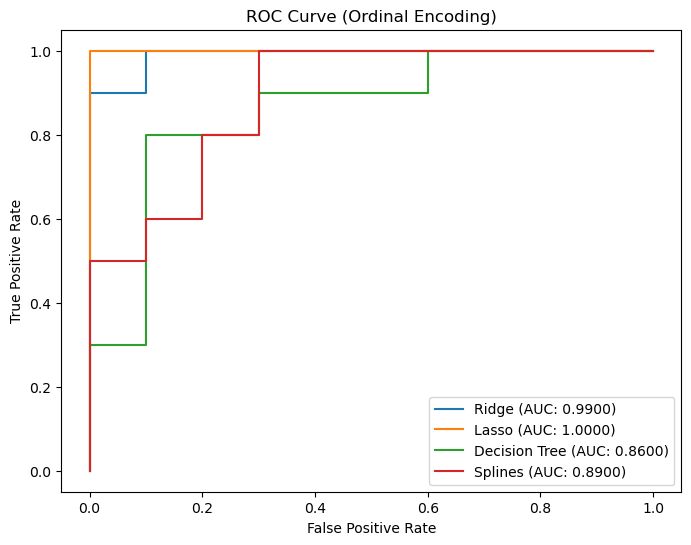


Evaluating One-Hot Encoding:
Ridge (One-Hot) - RMSE: 35.3632, AUC: 0.9700
Confusion Matrix:
[[ 9  1]
 [ 0 10]]
Lasso (One-Hot) - RMSE: 35.1490, AUC: 1.0000
Confusion Matrix:
[[ 9  1]
 [ 0 10]]
Decision Tree (One-Hot) - RMSE: 51.2065, AUC: 0.8800
Confusion Matrix:
[[8 2]
 [4 6]]
Splines (One-Hot) - RMSE: 50.7484, AUC: 0.9100
Confusion Matrix:
[[ 6  4]
 [ 0 10]]


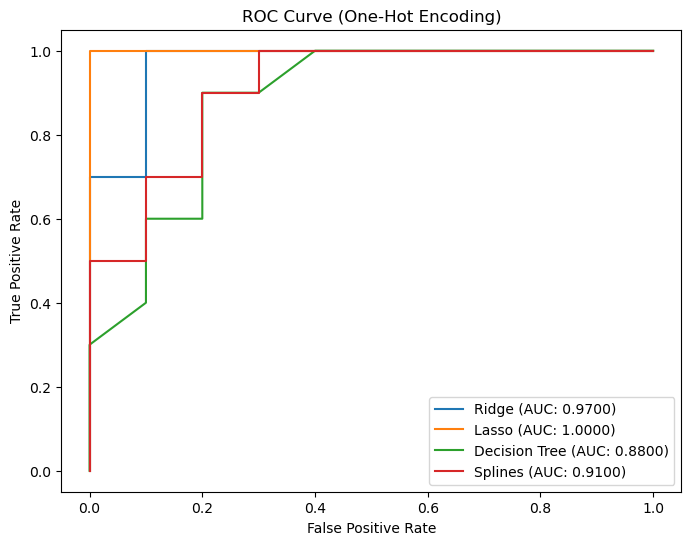

Best model: Ridge using Ordinal Encoding
Predictions, RMSE estimate, Confusion Matrix, AUC scores, and Feature Importance saved.


In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, SplineTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, roc_curve

# Load the datasets
data = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data.csv")
xnew = pd.read_csv(r"C:\Users\snehi\Documents\CDA_Assignments\case1Data_Xnew.csv")

# Identify categorical and numerical columns
categorical_cols = ['C_01', 'C_02', 'C_03', 'C_04', 'C_05']
numerical_cols = [col for col in data.columns if col not in categorical_cols + ['y']]

# Handle missing values
num_imputer = SimpleImputer(strategy='mean')
data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
xnew[numerical_cols] = num_imputer.transform(xnew[numerical_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])
xnew[categorical_cols] = cat_imputer.transform(xnew[categorical_cols])

# Option 1: Ordinal Encoding
ordinal_encoder = OrdinalEncoder()
data_ordinal = data.copy()
data_ordinal[categorical_cols] = ordinal_encoder.fit_transform(data_ordinal[categorical_cols])
xnew_ordinal = xnew.copy()
xnew_ordinal[categorical_cols] = ordinal_encoder.transform(xnew_ordinal[categorical_cols])

# Option 2: One-Hot Encoding
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
data_onehot = data.copy()
xnew_onehot = xnew.copy()
data_onehot_encoded = encoder.fit_transform(data_onehot[categorical_cols])
xnew_onehot_encoded = encoder.transform(xnew_onehot[categorical_cols])
data_onehot = data_onehot.drop(columns=categorical_cols).reset_index(drop=True)
xnew_onehot = xnew_onehot.drop(columns=categorical_cols).reset_index(drop=True)
data_onehot = pd.concat([data_onehot, pd.DataFrame(data_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)
xnew_onehot = pd.concat([xnew_onehot, pd.DataFrame(xnew_onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))], axis=1)

# Standardize numerical features
scaler = StandardScaler()
data_ordinal[numerical_cols] = scaler.fit_transform(data_ordinal[numerical_cols])
data_onehot[numerical_cols] = scaler.transform(data_onehot[numerical_cols])
xnew_ordinal[numerical_cols] = scaler.transform(xnew_ordinal[numerical_cols])
xnew_onehot[numerical_cols] = scaler.transform(xnew_onehot[numerical_cols])

# Split data into training and testing sets
X_ord, X_test_ord, y_ord, y_test_ord = train_test_split(data_ordinal.drop(columns=['y']), data_ordinal['y'], test_size=0.2, random_state=42)
X_oh, X_test_oh, y_oh, y_test_oh = train_test_split(data_onehot.drop(columns=['y']), data_onehot['y'], test_size=0.2, random_state=42)

# Define models
models = {
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "Decision Tree": DecisionTreeRegressor(),
    "Splines": make_pipeline(SplineTransformer(n_knots=5, degree=3), LinearRegression())
}

# Function to train, evaluate models, and plot AUC

def evaluate_models(X_train, X_test, y_train, y_test, encoding_type):
    results = {}
    plt.figure(figsize=(8, 6))
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        y_test_binary = (y_test > np.median(y_test)).astype(int)
        y_pred_binary = (y_pred > np.median(y_test)).astype(int)
        cm = confusion_matrix(y_test_binary, y_pred_binary)
        auc = roc_auc_score(y_test_binary, y_pred)
        fpr, tpr, _ = roc_curve(y_test_binary, y_pred)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {auc:.4f})')
        results[name] = rmse
        print(f"{name} ({encoding_type}) - RMSE: {rmse:.4f}, AUC: {auc:.4f}")
        print(f"Confusion Matrix:\n{cm}")
        
        # Print feature importance if using Ordinal Encoding with Ridge or Lasso
        if encoding_type == "Ordinal" and isinstance(model, (Ridge, Lasso)):
            coef_df = pd.DataFrame({"Feature": X_train.columns, "Coefficient": model.coef_})
            coef_df = coef_df.sort_values(by="Coefficient", ascending=False)
            print(f"\nFeature Importance ({name} - Ordinal Encoding):\n", coef_df.head(10))
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve ({encoding_type} Encoding)')
    plt.legend()
    plt.show()
    return results

# Evaluate models for both encodings
print("\nEvaluating Ordinal Encoding:")
results_ordinal = evaluate_models(X_ord, X_test_ord, y_ord, y_test_ord, "Ordinal")
print("\nEvaluating One-Hot Encoding:")
results_onehot = evaluate_models(X_oh, X_test_oh, y_oh, y_test_oh, "One-Hot")

# Select best model
best_encoding = "Ordinal" if min(results_ordinal.values()) < min(results_onehot.values()) else "One-Hot"
best_model = min(models, key=lambda m: results_ordinal[m] if best_encoding == "Ordinal" else results_onehot[m])
print(f"Best model: {best_model} using {best_encoding} Encoding")

# Make predictions on xnew
X_final = xnew_ordinal if best_encoding == "Ordinal" else xnew_onehot
final_model = models[best_model]
final_model.fit(data_ordinal.drop(columns=['y']) if best_encoding == "Ordinal" else data_onehot.drop(columns=['y']), data['y'])
ynew_pred = final_model.predict(X_final)

# Estimate RMSE using cross-validation
rmse_estimates = -cross_val_score(final_model, data_ordinal.drop(columns=['y']) if best_encoding == "Ordinal" else data_onehot.drop(columns=['y']), data['y'], scoring='neg_root_mean_squared_error', cv=5)
rmse_estimate = np.mean(rmse_estimates)

print("Predictions, RMSE estimate, Confusion Matrix, AUC scores, and Feature Importance saved.")
